In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.dummy import DummyRegressor

In [3]:
raw_df = pd.read_excel(r"C:\Users\ajs8911\OneDrive - The Pennsylvania State University\Research\System Analysis\Machine learning\ecoinvent 3.9.1_cutoff_cumulative_lcia_xlsx\Cut-off Cumulative LCIA v3.9.1.xlsx", sheet_name= ['LCIA'])
raw_df = raw_df['LCIA'] # convert from dict of pd.df to a pd.df

In [4]:
raw_df.iloc[:,4]

0                           NaN
1                           NaN
2        Reference Product Unit
3                            kg
4                            kg
                  ...          
21236                        kg
21237                        kg
21238                        kg
21239                        kg
21240                        kg
Name: Unnamed: 4, Length: 21241, dtype: object

In [5]:
raw_df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Method,CML v4.8 2016 no LT,CML v4.8 2016 no LT.1,CML v4.8 2016 no LT.2,CML v4.8 2016 no LT.3,...,TRACI v2.1.7,TRACI v2.1.8,USEtox no LT,USEtox no LT.1,USEtox no LT.2,USEtox no LT.3,USEtox,USEtox.1,USEtox.2,USEtox.3
0,NaN,NaN,NaN,NaN,NaN,Category,acidification no LT,climate change no LT,ecotoxicity: freshwater no LT,ecotoxicity: marine no LT,...,particulate matter formation,photochemical oxidant formation,ecotoxicity no LT,human toxicity no LT,human toxicity no LT,human toxicity no LT,ecotoxicity,human toxicity,human toxicity,human toxicity
1,NaN,NaN,NaN,NaN,NaN,Indicator,"acidification (incl. fate, average Europe tota...",global warming potential (GWP100) no LT,freshwater aquatic ecotoxicity (FAETP inf) no LT,marine aquatic ecotoxicity (MAETP inf) no LT,...,particulate matter formation potential (PMFP),maximum incremental reactivity (MIR),total no LT,carcinogenic no LT,non-carcinogenic no LT,total no LT,total,carcinogenic,non-carcinogenic,total
2,Activity UUID_Product UUID,Activity Name,Geography,Reference Product Name,Reference Product Unit,Reference Product Amount,kg SO2-Eq,kg CO2-Eq,"kg 1,4-DCB-Eq","kg 1,4-DCB-Eq",...,kg PM2.5-Eq,kg O3-Eq,CTU,CTU,CTU,CTU,CTU,CTU,CTU,CTU
3,9358a211-ce2b-56d3-b2f2-db5ffce81e33_807906d0-...,"1,1-difluoroethane production, HFC-152a",RoW,"1,1-difluoroethane, HFC-152a",kg,1,0.03478,5.985277,0.069555,6577.139937,...,0.00601,0.278267,3.106977,0.0,0.000001,0.000001,77.838227,0.0,0.000003,0.000003
4,9b228f7c-b4a4-57bf-8adf-8c5638d5741a_807906d0-...,"1,1-difluoroethane production, HFC-152a",US,"1,1-difluoroethane, HFC-152a",kg,1,0.032655,5.942792,0.074602,6495.718244,...,0.006298,0.269658,3.308264,0.0,0.000001,0.000002,91.007005,0.0,0.000003,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,dc2ffe87-92f2-51aa-a418-e257722f8b12_08663c56-...,zirconium oxide to generic market for electrol...,GLO,"electrolyte, for solid oxide fuel cell",kg,1,0.024739,4.11642,0.052119,2811.115428,...,0.004261,0.369785,1.765134,0.0,0.000001,0.000001,36.993278,0.0,0.000001,0.000002
21237,2082051a-a1a6-5ff7-9dbf-c401114d8c74_11985fce-...,"zirconium sponge production, from zirconium te...",FR,"zirconium sponge, nuclear-grade",kg,1,0.104039,18.677013,0.740605,23953.712183,...,0.016938,1.398065,51.372817,0.000004,0.000003,0.000008,893.099826,0.000018,0.000009,0.000027
21238,05ceb2fb-2059-56a8-88ba-a1fc10bf723a_11985fce-...,"zirconium sponge production, from zirconium te...",RoW,"zirconium sponge, nuclear-grade",kg,1,0.184496,33.700018,0.774872,36099.246853,...,0.03934,2.406116,52.898319,0.000004,0.000004,0.000009,920.634176,0.000019,0.00001,0.000029
21239,0ef88c14-66dc-56ef-b3be-bb90df35040b_11985fce-...,"zirconium sponge production, from zirconium te...",US,"zirconium sponge, nuclear-grade",kg,1,0.17264,31.189363,0.750844,32861.177878,...,0.036587,2.066193,52.088642,0.000004,0.000004,0.000008,920.406542,0.000019,0.00001,0.000029


In [6]:
X_raw = raw_df.iloc[:,0:6]
X1 = X_raw.iloc[3:,0:6]
X1.columns = X_raw.iloc[2,0:6]
X1.head()

2,Activity UUID_Product UUID,Activity Name,Geography,Reference Product Name,Reference Product Unit,Reference Product Amount
3,9358a211-ce2b-56d3-b2f2-db5ffce81e33_807906d0-...,"1,1-difluoroethane production, HFC-152a",RoW,"1,1-difluoroethane, HFC-152a",kg,1
4,9b228f7c-b4a4-57bf-8adf-8c5638d5741a_807906d0-...,"1,1-difluoroethane production, HFC-152a",US,"1,1-difluoroethane, HFC-152a",kg,1
5,c44762a4-1b99-5c2a-a2c2-d22e96880970_c6c77fb4-...,"1,1-dimethylcyclopentane to generic market for...",GLO,"solvent, organic",kg,1
6,7407f869-5681-5b26-8d97-7cc9a2d5e274_95aedd09-...,1-methoxy-2-propanol production,GLO,1-methoxy-2-propanol,kg,1
7,ce4db458-1505-59eb-a4f5-c5f32d8479ee_e24e6570-...,1-methylcyclopropene production,GLO,1-methylcyclopropene,kg,1


In [7]:
X2 = X1.drop(['Activity UUID_Product UUID', 'Activity Name', 'Reference Product Name', 'Reference Product Unit'], axis='columns')
X2.head()

2,Geography,Reference Product Amount
3,RoW,1
4,US,1
5,GLO,1
6,GLO,1
7,GLO,1


In [8]:
y_raw = raw_df.iloc[:,7:]
dropcolumns = y_raw.columns[y_raw.columns.str.contains('endpoint')]
dropcolumns1 = y_raw.columns[y_raw.columns.str.contains('Endpoint')]
y1 = y_raw.drop(dropcolumns, axis='columns')
y1 = y1.drop(dropcolumns1, axis='columns')
y1 = y1.columns[y1.apply(lambda x: x.str.contains("acidification").any() and not x.str.contains("no LT").any())]
y1

Index(['CML v4.8 2016', 'EDIP 2003', 'EF v3.0', 'EF v3.1',
       'IMPACT 2002+ (Midpoint)', 'ReCiPe 2016 v1.03, midpoint (E)',
       'ReCiPe 2016 v1.03, midpoint (H)', 'ReCiPe 2016 v1.03, midpoint (I)',
       'TRACI v2.1'],
      dtype='object')

In [9]:
y2 = y_raw.loc[3:, y1]
df1 = pd.DataFrame(y_raw.loc[:, y1].columns) # y df containing only the LCIA method names
y2 = y2.loc[y2.index.repeat(len(df1))].reset_index(drop=True)
y2

,CML v4.8 2016,EDIP 2003,EF v3.0,EF v3.1,IMPACT 2002+ (Midpoint),"ReCiPe 2016 v1.03, midpoint (E)","ReCiPe 2016 v1.03, midpoint (H)","ReCiPe 2016 v1.03, midpoint (I)",TRACI v2.1
0,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
1,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
2,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
3,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
4,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
...,...,...,...,...,...,...,...,...,...
191137,0.001064,0.017498,0.001513,0.001513,0.00127,0.000888,0.000888,0.000888,0.001271
191138,0.001064,0.017498,0.001513,0.001513,0.00127,0.000888,0.000888,0.000888,0.001271
191139,0.001064,0.017498,0.001513,0.001513,0.00127,0.000888,0.000888,0.000888,0.001271
191140,0.001064,0.017498,0.001513,0.001513,0.00127,0.000888,0.000888,0.000888,0.001271


In [10]:
import pandas as pd

# Create dataframe1
# df1 = y_raw.loc[:, y_ind].iloc[0:3,:].T
df1 = pd.DataFrame(y_raw.loc[:, y1].columns) # y df containing only the LCIA method names
df3 = pd.DataFrame(y_raw.loc[3:, y1].values.reshape(1, -1)[0]) # reshape the y df to be a single column of values

# Create dataframe2
df2 = X2

# Expand dataframe2 to repeat each row for each row in dataframe1
df2_expanded = df2.loc[df2.index.repeat(len(df1))].reset_index(drop=True)

# Repeat dataframe1 to match the expanded dataframe2
df1_repeated = pd.concat([df1]*len(df2)).reset_index(drop=True)

# Combine the expanded dataframe2 with the repeated dataframe1
X3 = pd.concat([df2_expanded, df1_repeated, df3], axis=1)

# Rename the columns for clarity
X3.columns = list(df2.columns) + ['LCIA_method', 'Impact']

# # Apply the transformation: if 'acidification' in Category_1 or Category_2, set Category_1 to 'acidification'
# df_result.loc[(df_result['Category_1'].str.contains('acidification')) | (df_result['Category_2'].str.contains('acidification')), 'Category_1'] = 'acidification'

X3

,Geography,Reference Product Amount,LCIA_method,Impact
0,RoW,1,CML v4.8 2016,0.03478
1,RoW,1,EDIP 2003,0.578012
2,RoW,1,EF v3.0,0.040276
3,RoW,1,EF v3.1,0.040276
4,RoW,1,IMPACT 2002+ (Midpoint),0.032736
...,...,...,...,...
191137,GLO,1,IMPACT 2002+ (Midpoint),0.00127
191138,GLO,1,"ReCiPe 2016 v1.03, midpoint (E)",0.000888
191139,GLO,1,"ReCiPe 2016 v1.03, midpoint (H)",0.000888
191140,GLO,1,"ReCiPe 2016 v1.03, midpoint (I)",0.000888


In [70]:
X_short = X3.iloc[0:100,:]
y_short = y2.iloc[0:100,:]

ohe = OneHotEncoder()
ohe.fit(X_short.iloc[0:100,0:3])
ohe_transform = pd.DataFrame(ohe.transform(X_short.iloc[0:100,0:3]).toarray())
# ohe.categories_

# scaler = StandardScaler()
# scaler_transform = pd.DataFrame(scaler.fit_transform(X_short.loc[:,'Impact'].values.reshape(-1, 1))) # can't handle outliers well https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section

# robust_scaler = RobustScaler()
# robust_scaler_transform = pd.DataFrame(robust_scaler.fit_transform(X_short.loc[:,'Impact'].values.reshape(-1, 1)))

# rz_scores = np.abs((robust_scaler_transform - np.mean(robust_scaler_transform, axis=0)) / np.std(robust_scaler_transform, axis=0))
# rthreshold = 3
# routliers = np.where(rz_scores > rthreshold)
# robust_scaler_transform = pd.DataFrame(np.delete(robust_scaler_transform, routliers[0], axis=0))
# ohe_transform = pd.DataFrame(np.delete(ohe_transform, routliers[0], axis=0))
# y_short = pd.DataFrame(np.delete(y_short, routliers[0], axis=0))

# X_short = pd.concat([ohe_transform,scaler_transform], axis='columns')
# X_short = pd.concat([ohe_transform,robust_scaler_transform], axis='columns')
X_short = pd.concat([ohe_transform,ohe_transform], axis='columns')

X_short = X_short.values

X_train, X_test, y_train, y_test = train_test_split(X_short, y_short, test_size=0.1, random_state=42)

rdf = RandomForestRegressor(n_estimators=100, random_state=42)
rdf.fit(X_train, y_train)

y_pred = rdf.predict(X_test)

In [36]:
# Check for outliers using Z-score
z_scores = np.abs((scaler_transform - np.mean(scaler_transform, axis=0)) / np.std(scaler_transform, axis=0))
threshold = 3
outliers = np.where(z_scores > threshold)

rz_scores = np.abs((robust_scaler_transform - np.mean(robust_scaler_transform, axis=0)) / np.std(robust_scaler_transform, axis=0))
rthreshold = 3
routliers = np.where(rz_scores > rthreshold)

# X_clean = np.delete(scaler_transform, outliers[0], axis=0)
# y_clean = np.delete(y, outliers[0], axis=0)

In [70]:
rz_scores[0][routliers[0]]

1     4.751203
10    4.455631
37    4.921079
64    3.478626
Name: 0, dtype: float64

<Axes: ylabel='0'>

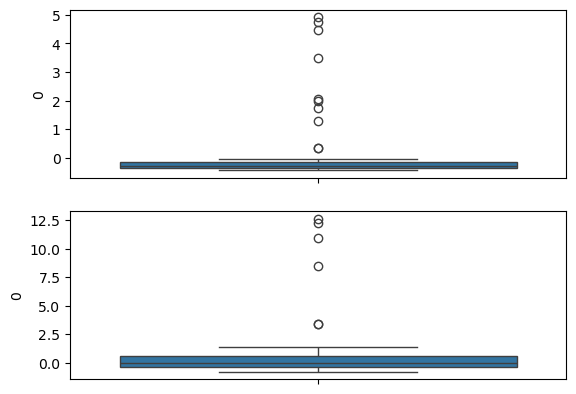

In [77]:
# Assume you want to check outliers for each feature
fig, (ax1, ax2) = plt.subplots(2)
sns.boxplot(ax=ax1, data=scaler_transform[0])
sns.boxplot(ax=ax2, data=robust_scaler_transform[0])


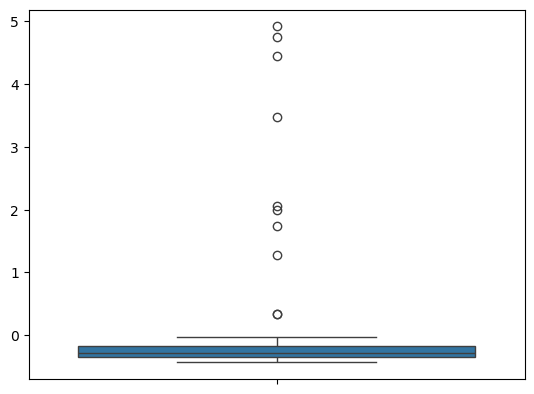

In [60]:
# Assume you want to check outliers for each feature
plt.figure()
sns.boxplot(data=X_short[:,-1])
plt.show()

In [84]:
y = y2.values

ohe = OneHotEncoder()
ohe.fit(X3.iloc[:,0:3])
ohe_transform = pd.DataFrame(ohe.transform(X3.iloc[:,0:3]).toarray())
# ohe.categories_

# scaler = StandardScaler()
# scaler_transform = pd.DataFrame(scaler.fit_transform(X3.loc[:,'Impact'].values.reshape(-1, 1)))

# robust_scaler = RobustScaler()
# robust_scaler_transform = pd.DataFrame(robust_scaler.fit_transform(X3.loc[:,'Impact'].values.reshape(-1, 1)))
# rz_scores = np.abs((robust_scaler_transform - np.mean(robust_scaler_transform, axis=0)) / np.std(robust_scaler_transform, axis=0))
# rthreshold = 1
# routliers = np.where(rz_scores > rthreshold)
# robust_scaler_transform = pd.DataFrame(np.delete(robust_scaler_transform, routliers[0], axis=0))
# ohe_transform = pd.DataFrame(np.delete(ohe_transform, routliers[0], axis=0))
# y = pd.DataFrame(np.delete(y2, routliers[0], axis=0))

# X = pd.concat([ohe_transform,scaler_transform], axis='columns')
# X = pd.concat([ohe_transform,robust_scaler_transform], axis='columns')
X = pd.concat([ohe_transform, X3.loc[:,'Impact']], axis='columns')
X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

rdf = RandomForestRegressor(n_estimators=1, random_state=42)
rdf.fit(X_train, y_train)

y_pred = rdf.predict(X_test)

# import pickle
# # Save the model to file
# pickle.dump(model, open("model_file.pkl", "wb"))

# # Restore the model from file
# restored_model = pickle.load(open("model_file.pkl", "rb"))

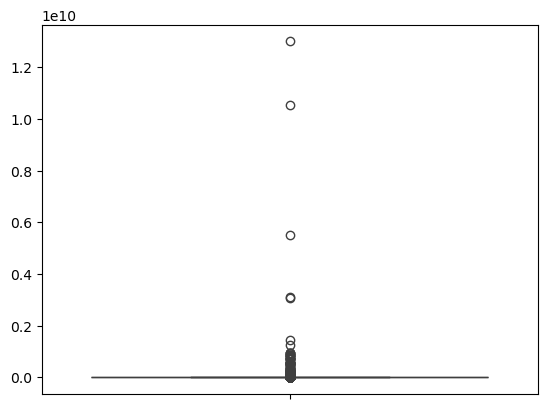

In [180]:
# Assume you want to check outliers for each feature
plt.figure()
sns.boxplot(data=X[:,-1])
plt.show()

Text(0, 0.5, 'predicted value')

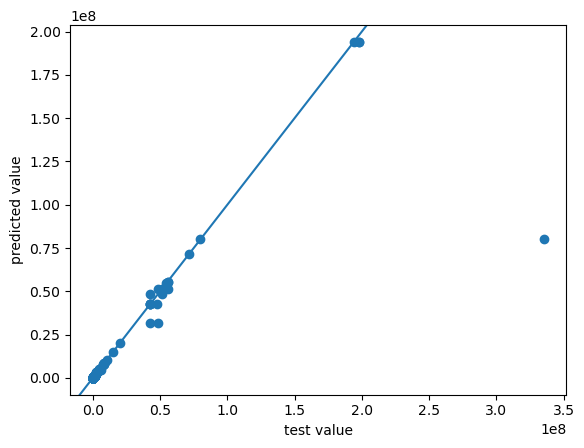

In [34]:
# true vs predicted value plot
fig, ax = plt.subplots()
ax.scatter(y_test[:,0], y_pred[:,0])
ax.axline((0,0), slope=1)
ax.set_xlabel('test value')
ax.set_ylabel('predicted value')

In [17]:
len(y_test[:,5])

19115

In [166]:
outlier = [i for i in range(len(y_test[:,0])) if y_test[i,0] > 3e8] # index for outlier
ohe.inverse_transform(X_test[outlier,0:320])

# why is that one point so far off?

array([['RER', 1, 'EDIP 2003']], dtype=object)

In [21]:
# Mean Squared Error
# --------------------------------------------------------------------------------
'''
A well-fitting regression model predicts values close to the observed data values. The mean
model, which always predicts the average of the training data labels, generally would be
used if there were no informative features. Therefore, the regression model should fit better
than that of the mean model. Thus, the mean model acts as a baseline. If the regression
model MSE is greater than the baseline MSE, then we have a problem in our regression
model. It may be overfitting or underfitting (we consider these in Section 5.8). It could
also be that the problem was defined with an error, or the programming code contains a bug.
- Machine Learning Engineering by Andriy Burkov
'''
dummy_model = DummyRegressor(strategy='mean') # DummyRegressor with strategy='mean' predicts the mean of the target values
dummy_model.fit(X_train, y_train)
y_dummy_pred = dummy_model.predict(X_test)
mse_dummy = mean_squared_error(y_test, y_dummy_pred, multioutput='raw_values')

mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
# print("MSE for each output:", mse)
print(f"MSE:   Average (STD)  |  {Decimal(mse.mean()):.2E} ({Decimal(mse.std()):.2E})                Dummy model  |  {Decimal(mse_dummy.mean()):.2E} ({Decimal(mse_dummy.std()):.2E})") 

# Median absolute error
# --------------------------------------------------------------------------------
'''
If the data contains outliers, the examples very far from the “true” regression line, they
can significantly affect the value of MSE. By definition, the squared error for such outlying
examples will be high. In such situations, it is better to apply a different metric, the median
absolute error, MdAE
- Machine Learning Engineering by Andriy Burkov
'''
mdae_dummy = median_absolute_error(y_test, y_dummy_pred, multioutput='raw_values')
mdae = median_absolute_error(y_test, y_pred, multioutput='raw_values')
# print("MdAE for each output:", mdae)
print(f"MdAE:  Average (STD)  |  {Decimal(mdae.mean()):.2E} ({Decimal(mdae.std()):.2E})                  Dummy model  |  {Decimal(mdae_dummy.mean()):.2E} ({Decimal(mdae_dummy.std()):.2E})")

# Almost Correct Predictions Error Rate (ACPER)
# --------------------------------------------------------------------------------
'''
The almost correct predictions error rate (ACPER) is the percentage of predictions
that is within p percentage of the true value. To calculate ACPER, proceed as follows:
1. Define a threshold percentage error that you consider acceptable (let’s say 2%).
2. For each true value of the target yi, the desired prediction should be between yi+0.02yi
and yi − 0.02yi.
3. By using all examples i = 1, . . . ,N, calculate the percentage of predicted values fulfilling
the above rule. This will give the value of the ACPER metric for your model.
- Machine Learning Engineering by Andriy Burkov
'''
# % of predicted values are within {p*100} % of the true value
def acper(y_true, y_pred, p):
    """
    Calculate the Almost Correct Predictions Error Rate (ACPER).
    
    Parameters:
    y_true (array-like): True values
    y_pred (array-like): Predicted values
    p (float): Percentage threshold (e.g., 0.1 for 10%)
    
    Returns:
    float: ACPER value
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the absolute percentage error
    absolute_percentage_error = np.abs((y_true - y_pred) / (y_true+0.000000001))
    
    # Calculate the ACPER
    acper_value = np.mean(absolute_percentage_error <= p) * 100
    
    return acper_value

# Calculate ACPER for each output
p = 0.2  # percentage threshold
n_outputs = y_test.shape[1]
acper_result = []
acper_result_dummy = []

for i in range(n_outputs):
    acper_value = acper(y_test[:, i], y_pred[:, i], p)
    acper_result.append(acper_value)

for i in range(n_outputs):
    acper_value_dummy = acper(y_test[:, i], y_dummy_pred[:, i], p)
    acper_result_dummy.append(acper_value_dummy)

acper_result = np.array(acper_result)
acper_result_dummy = np.array(acper_result_dummy)

print(f'ACPER: Average (STD)  |  {acper_result.mean():.2f} ({acper_result.std():.2f})                       Dummy model  |  {Decimal(acper_result_dummy.mean()):.2E} ({Decimal(acper_result_dummy.std()):.2E})') 






print("------------------------------------")
# R-squared
r2 = r2_score(y_test, y_pred, multioutput='raw_values')
# print("R-squared for each output:", r2)
print("Average R-squared:", r2.mean()) 

# Explained Variance
explained_variance = explained_variance_score(y_test, y_pred, multioutput='raw_values')
# print("Explained Variance for each output:", explained_variance)
print("Average Explained Variance:", explained_variance.mean())

MSE:   Average (STD)  |  1.01E+14 (2.75E+14)                Dummy model  |  4.40E+14 (1.20E+15)
MdAE:  Average (STD)  |  1.92E-5 (3.83E-5)                  Dummy model  |  4.45E+5 (8.13E+5)
ACPER: Average (STD)  |  91.54 (1.33)                       Dummy model  |  1.50E-1 (7.40E-3)
------------------------------------
Average R-squared: 0.7691670739111907
Average Explained Variance: 0.7691828397477924


In [28]:
from sklearn.model_selection import KFold

rdf = RandomForestRegressor(n_estimators=1, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
folds = kf.split(X, y)
for i, j in folds:
    print(i)
    print("---")
    print(j)
    print("-------------------------")


# y_pred = []

for train_index, test_index in folds:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # rdf.fit(X_train, y_train)
    # y_pred.append(rdf.predict(X_test))

# y_pred

[     0      2      5 ... 191138 191139 191141]
---
[     1      3      4 ... 191131 191133 191140]
-------------------------
[     0      1      2 ... 191139 191140 191141]
---
[     6      8     10 ... 191126 191130 191134]
-------------------------
[     0      1      2 ... 191138 191140 191141]
---
[    23     28     33 ... 191117 191128 191139]
-------------------------
[     0      1      3 ... 191135 191139 191140]
---
[     2     11     15 ... 191137 191138 191141]
-------------------------
[     1      2      3 ... 191139 191140 191141]
---
[     0      5      7 ... 191123 191132 191135]
-------------------------


In [86]:
# Example data
# X = X_short
# y = y2.iloc[0:100,:].values

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Create a combined label for stratification
# This combines the multioutput targets into a single label for stratification
combined_labels = np.array([hash(tuple(row)) for row in y])

# Initialize model
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=1))

# Stratified k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

mse_scores = []

for train_idx, test_idx in skf.split(X, combined_labels):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]
    
    # Clone the model to ensure a fresh start for each fold
    cloned_model = clone(model)
    cloned_model.fit(X_train, Y_train)
    Y_pred = cloned_model.predict(X_test)
    
    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    mse_scores.append(mse)

# Mean MSE score for each output
mean_mse_scores = np.mean(mse_scores, axis=0)
print("Mean MSE scores for each output:", mean_mse_scores)



In [78]:
X.shape

(100, 28)

In [80]:
y.shape

(100, 9)

In [81]:
X

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [82]:
y

,CML v4.8 2016,EDIP 2003,EF v3.0,EF v3.1,IMPACT 2002+ (Midpoint),"ReCiPe 2016 v1.03, midpoint (E)","ReCiPe 2016 v1.03, midpoint (H)","ReCiPe 2016 v1.03, midpoint (I)",TRACI v2.1
0,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
1,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
2,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
3,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
4,0.03478,0.578012,0.040276,0.040276,0.032736,0.028494,0.028494,0.028494,0.032945
...,...,...,...,...,...,...,...,...,...
95,0.01166,0.191865,0.013981,0.013981,0.011696,0.009406,0.009406,0.009406,0.011702
96,0.01166,0.191865,0.013981,0.013981,0.011696,0.009406,0.009406,0.009406,0.011702
97,0.01166,0.191865,0.013981,0.013981,0.011696,0.009406,0.009406,0.009406,0.011702
98,0.01166,0.191865,0.013981,0.013981,0.011696,0.009406,0.009406,0.009406,0.011702
